
# Week 1 Delivery

Authors: *Aitor Sánchez, Andreu Rodríguez and Laura Mora*


The purpose of this project is to familiarize with the SIFT descriptor as a feature and descriptor method as well as The Bag Of Words (BOW) model.

In the project, we are given a dataset with different classes of images, divided in both train and test. In the given code, the SIFT descriptor is created for a given number of features, then a Kmeans clustering is applied for training purposes. Finally, for both training and testing, a KNeighbours classifier is applied to classify the dataset into the different classes.


In order to test the model, several parameters have been changed:


*   Test other amounts of local features.
* Dense SIFT (local descriptors computed every n pixels at different scales). 
* Test different amounts of codebook sizes k.
*  Test different values of k for the k-nn classifier.
* Test other distances for the k-nn classifier.


Also, another SIFT method, RootSift, has been implemented.

## Import Packages and Method Definition

In [2]:
import cv2
import numpy as np
import pickle
import time

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def open_pkl(pkl_file):
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)    
    return data

# Set your path
%cd /Users/lauram/Documents/M3/Projecte/M3-18.19/notebook/original

/Users/lauram/Documents/M3/Projecte/M3-18.19/notebook/original


In [3]:
def create_BOW(dense, sift_step_size, k_codebook, n_features):
    
    train_images_filenames = open_pkl('train_images_filenames.dat')
    train_labels = open_pkl('train_labels.dat')

    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=n_features)
    
    kpt = [cv2.KeyPoint(x, y, sift_step_size) for y in range(0, 256, sift_step_size) for x in range(0, 256, sift_step_size)]
    
    Train_descriptors = []
    Train_label_per_descriptor = []
     
    for filename, labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if dense:
            (kp, des) = SIFTdetector.compute(gray, kpt)
        else:
            (kp, des) = SIFTdetector.detectAndCompute(gray, None)
            
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    
    D = np.vstack(Train_descriptors)
    codebook = MiniBatchKMeans(n_clusters=k_codebook, verbose=False, batch_size=k_codebook * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)
    
    # Init 
    visual_words = np.zeros((len(Train_descriptors),k_codebook),dtype=np.float32)

    for i in range(len(Train_descriptors)):

        words = codebook.predict(Train_descriptors[i])
        visual_words[i,:] = np.bincount(words, minlength = k_codebook)
        
    return codebook, visual_words


In [4]:
def classify_BOW(dense, sift_step_size, k_codebook, visual_words, codebook, k_classifier, distance_method, n_features):
    
    test_images_filenames = open_pkl('test_images_filenames.dat')
    test_labels = open_pkl('test_labels.dat')
    train_labels = open_pkl('train_labels.dat')
    
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=n_features)
    
    kpt = [cv2.KeyPoint(x, y, sift_step_size) for y in range(0, 256, sift_step_size) for x in range(0, 256, sift_step_size)]
    
    knn = KNeighborsClassifier(n_neighbors=k_classifier, n_jobs=-1, metric=distance_method)
    knn.fit(visual_words, train_labels) 
    
    visual_words_test=np.zeros((len(test_images_filenames),k_codebook),dtype=np.float32)
    
    for i in range(len(test_images_filenames)):
    
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if dense:
            (kp, des) = SIFTdetector.compute(gray, kpt)
        else:
            (kp, des) = SIFTdetector.detectAndCompute(gray,None)  
            
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k_codebook)
        
    accuracy = 100*knn.score(visual_words_test, test_labels)
    
    return accuracy


##  Amount of local features using SIFT

The first parameter which has been modified is the amount of **local features** used by the  SIFT detector and descriptor. For this, the kmeans codebook size(k) at 128 as well as k-nn classifier has been fixed at 5. The used distance is Euclidean distance. 


In [4]:
    dense = False                  # Dense Sift set to false
    sift_step_size = 20            # Amount of features for the DenseSift
    k_codebook = 128               # Kmeans codebook size
    k_classifier = 5               # K-Neighbours for the KNN Classifier
    distance_method = 'euclidean'  # Similarity Measure
    

To monitor the effect of changing the number of features extracted in SIFT, we have computed SIFT from 50 features to 800 in intervals of 50. As seen in the plot "SIFT: Features - Accuracy - Time", the accuracy increases significantly in the first intervals and it is stabilized when arriving to 350 features and the maximum accuracy is achieved at almost 60%. Regarding computational time, it increases directly proportional to the number of features, starting in 52 seconds for 50 features and ending in 78 seconds with 800 features. 

As explained in the practicum reference paper *Distinctive Image Features from Scale-Invariant Keypoints, from the professor David G. Lowe, “the features are highly distinctive, in the sense that a single feature can be correctly matched with high probability against a large database of features from many images”*. So, a higher number of features are not a guarantee of an accuracy improval since results converge in a given point.


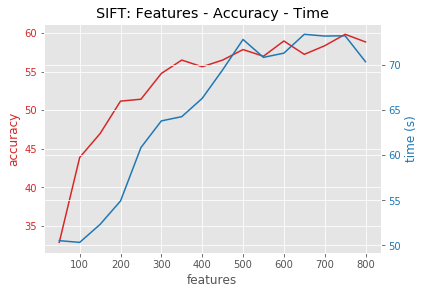

In [5]:
    accuracy_list = []    
    time_list = [] 
    for n_features in range(50,801,50):
        start = time.time()
        codebook, visual_words = create_BOW(dense, sift_step_size, k_codebook, n_features)
        accuracy_list.append(classify_BOW(dense, sift_step_size, k_codebook, visual_words, codebook, k_classifier, distance_method,n_features))
        end = time.time()
        time_list.append(end - start)
        
    fig, ax1 =plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('features')
    ax1.set_ylabel('accuracy', color=color)
    ax1.plot(list(range(50,801,50)), accuracy_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('time (s)', color=color)  # we already handled the x-label with ax1
    ax2.plot(list(range(50,801,50)),time_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("SIFT: Features - Accuracy - Time")
    plt.show()

## Dense SIFT - Local descriptors computed every n pixels at different scales

The main difference between SIFT and dense SIFT is that, in dense SIFT, the SIFT descriptor is computed at every location -every n pixels- whereas SIFT locations are determined by Lowe’s algorithm. Some research works show that, using dense SIFT, better results can be obtained.

To test the Dense Sift method, we have changed the different step sizes for defining the keypoints.  The values vary from 10 to 90 increasing 10 points at every step. In this case, the same parameters as in SIFT are fixed: the kmeans codebook size(k) at 128, the k-nn classifier has been fixed at 5 and the used distance is Euclidean.

In [6]:
    dense = True                  # Dense Sift set to true
    k_codebook = 128              # Kmeans codebook size
    k_classifier = 5              # K-Neighbours for the KNN Classifier
    distance_method = 'euclidean' # Similarity Measure
    

In the case of dense SIFT, as said before, some research works state that dense SIFT results are better than the ones obtained by using SIFT. As seen in the next graphic, dense SIFT results are around a ten percent more accurate than SIFT results with almost the same computational cost. 


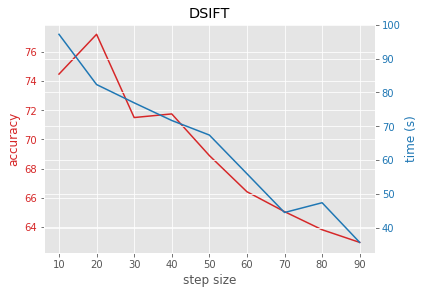

In [7]:
    accuracy_list = []    
    time_list = []
    
    for sift_step_size in range(10,91,10):
        start = time.time()
        codebook, visual_words = create_BOW(dense, sift_step_size, k_codebook, n_features)
        accuracy_list.append(classify_BOW(dense, sift_step_size, k_codebook, visual_words, codebook, k_classifier, distance_method,n_features))
        end = time.time()
        time_list.append(end - start)
        
    fig, ax1 =plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('step size')
    ax1.set_ylabel('accuracy', color=color)
    ax1.plot(list(range(10,91,10)), accuracy_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('time (s)', color=color)  # we already handled the x-label with ax1
    ax2.plot(list(range(10,91,10)),time_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("DSIFT")
    plt.show()   

## Changing the Codebook size k

As stated in  *Tanuja K. and Mandal N. K-Means Codebook optimization using KFCG Clustering Technique, “Codebook optimization is a concept of vector quantization which is applied to achieve lossy compression”*.

In our case, we started by using a clustering k equal to 32 and increase it with intervals of 32 until 256. For this, we have fixed the SIFT to 20, used an Euclidean distance and a k-knn classifier equal to 5.


In [8]:
    sift_step_size = 20           # Amount of features for the DenseSift
    k_classifier = 5              # K-Neighbours for the KNN Classifier
    distance_method = 'euclidean' # Similarity Measure
    

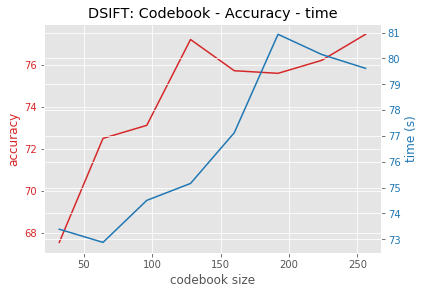

In [9]:
    accuracy_list = []    
    time_list = [] 
    
       
    for k_codebook in range(32,257,32):
        start = time.time()
        codebook, visual_words = create_BOW(dense, sift_step_size, k_codebook, n_features)
        accuracy_list.append(classify_BOW(dense, sift_step_size, k_codebook, visual_words, codebook, k_classifier, distance_method,n_features))
        end = time.time()
        time_list.append(end - start)
        
    fig, ax1 =plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('codebook size')
    ax1.set_ylabel('accuracy', color=color)
    ax1.plot(list(range(32,257,32)), accuracy_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('time (s)', color=color)  # we already handled the x-label with ax1
    ax2.plot(list(range(32,257,32)),time_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("DSIFT: Codebook - Accuracy - time")
    plt.show()    

## Changing Number of Neighbours and Similarity Measurement

To decide the number of Neighbours in the classifier, we have only taken into account the odd numbers so the algorithm can have quorum to avoid split brain. The test values for the classifier go from 1 to 9. Although, the number of neighbours should be, at least, the number of classes that we have, which is six. This is the reason why the most significant results are obtained with 7 and 9 neighbours. 

First, we perform the testing by fixing the number of keypoints to 20, a codebook size of 128 and the euclidian distance.

In [9]:
    dense = True
    n_features = 400
    k_codebook = 128              # Kmeans codebook size
    sift_step_size = 20           # Amount of features for the DenseSift
    distance_method = 'euclidean' # Similarity Measure

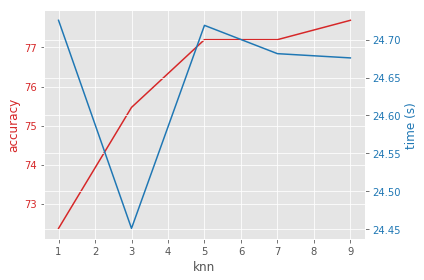

In [11]:
    accuracy_list = []    
    time_list = []    
    codebook, visual_words = create_BOW(dense, sift_step_size, k_codebook, n_features)   
    
    for k_classifier in range(1,11,2):
        start = time.time()
        accuracy_list.append(classify_BOW(dense, sift_step_size, k_codebook, visual_words, codebook, k_classifier, distance_method, n_features))
        end = time.time()
        time_list.append(end - start)
        
    fig, ax1 =plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('knn')
    ax1.set_ylabel('accuracy', color=color)
    ax1.plot(list(range(1,11,2)), accuracy_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('time (s)', color=color)  # we already handled the x-label with ax1
    ax2.plot(list(range(1,11,2)),time_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()   

Finally a different set of metric for the distance have been compared among them. Euclidean and manhattan presents the betters results.

In [12]:
    distance_methods = ['euclidean', 'manhattan', 'chebyshev', 'hamming']

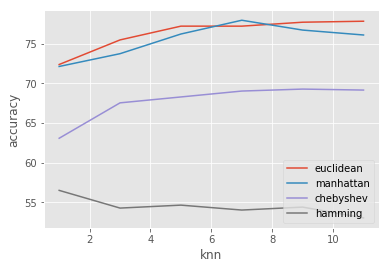

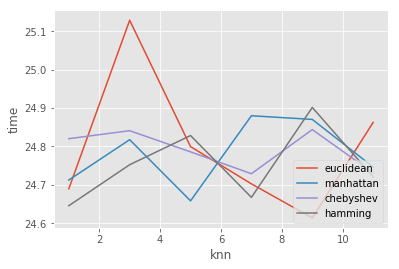

In [13]:
    accuracy_list = []    
    time_list = []    
    codebook, visual_words = create_BOW(dense, sift_step_size, k_codebook, n_features)   
    for distance_method in distance_methods:
        accuracy_temp = []    
        time_temp = []   
        for k_classifier in range(1,12,2):        
            start = time.time()
            accuracy_temp.append(classify_BOW(dense, sift_step_size, k_codebook, visual_words, codebook, k_classifier, distance_method,n_features))
            end = time.time()
            time_temp.append(end - start)
        accuracy_list.append(accuracy_temp)
        time_list.append(time_temp)
        
    plt.figure()        
    plt.xlabel('knn')
    plt.ylabel('accuracy')
    for item, label_distance in zip(accuracy_list, distance_methods):
        plt.plot(list(range(1,12,2)), item, label = label_distance )
    plt.legend(loc = 4)
    plt.show()    
    plt.figure()
    plt.xlabel('knn')
    plt.ylabel('time')
    for item, label_distance in zip(time_list, distance_methods):
        plt.plot(list(range(1,12,2)), item, label = label_distance )
    plt.legend(loc = 4)
    plt.show() 

## Conclusions

* Dense SIFT provides better results than SIFT.
* Enlarging the number of keypoints in SIFT improves the results until a certain point -convergence point-. If more keypoints are added the computational cost will increase with the same or worst results. 
* Euclidean and Manhattan distances are the ones which provided better results -around an 80%-.
* The codebook size k provides almost the same results from 128 on.